# k-d Trees

k-d trees speed up nearest neighbor search in low dimensions, but they have considerable overhead as compared to a simple brute force search. Let's code up a k-d tree in Python.

In [45]:
import numpy as np
from typing import Union, Optional, Set
from dataclasses import dataclass
import matplotlib.pyplot as plt
import matplotlib as mpl
%config InlineBackend.figure_format='retina'
mpl.rcParams['figure.figsize'] = (10, 10)

Now we implement the k-d tree and its associated functions. Unlike with the previous BSTs, we'll just use a standalone node class without a "tree" class. Querying the tree will be done with module-level functions instead of instance methods. You could design it differently, but this is nice and simple.

Internal nodes of the k-d tree are questions. We'll design a `KDInternalNode` class for representing these nodes. Leaf nodes are simply sets of points that we store in a ndarray.

In [46]:
@dataclass(init=True)
class KDInternalNode:
    """An internal node in a k-d tree."""
    
    # the left and right children, which are either KDInternalNodes or
    # leaf nodes (ndarrays)
    left: Union['KDInternalNode', np.ndarray]
    right: Union['KDInternalNode', np.ndarray]
        
    # the question's threshold and the dimension it refers to
    # Given an array representing a point, this asks:
    # is point[dimension] >= threshold?
    threshold: float
    dimension: int
        
    def __repr__(self):
        return f'KDInternalNode(dimension={self.dimension}, threshold={self.threshold})'

## Construction

Here is a bit of code to construct a k-d tree. It is more memory-efficient than the code given in lecture. It chooses the dimension with largest spread to be the splitting dimension, and uses the median as the threshold.

In [47]:
def build_kd_tree(data, m=5):
    """Construct a k-d tree from data.
    
    Parameters
    ----------
    data : ndarray
        An n x d array of n points in d dimensional space.
    m : int
        The max leaf node size. Default: 5
        
    Returns
    -------
    KDInternalNode or ndarray
        The root node of the k-d tree. If the number of the points in
        the tree is <5, returns the input ndarray.
    """
    if len(data) <= m:
        return data.copy()
    
    # find the dimension with greatest spread
    spread = data.max(axis=0) - data.min(axis=0)
    splitting_dimension = np.argmax(spread)
    
    # partition the data in-place around the median
    sort_ix = np.argpartition(data[:, splitting_dimension], len(data) // 2)
    data[:] = data[sort_ix]
    threshold = data[len(data) // 2, splitting_dimension]
    
    left_data, right_data = np.split(data, [len(data) // 2])
    
    left = build_kd_tree(left_data, m=m)
    right = build_kd_tree(right_data, m=m)
    
    return KDInternalNode(left=left, right=right, threshold=threshold, dimension=splitting_dimension)

Let's test it out on a sample data set with two clusters:

In [48]:
np.random.seed(42)
data_1 = np.random.normal(size=(40, 2))
data_2 = np.random.normal(loc=[5,2], size=(60, 2))
data = np.vstack((data_1, data_2))

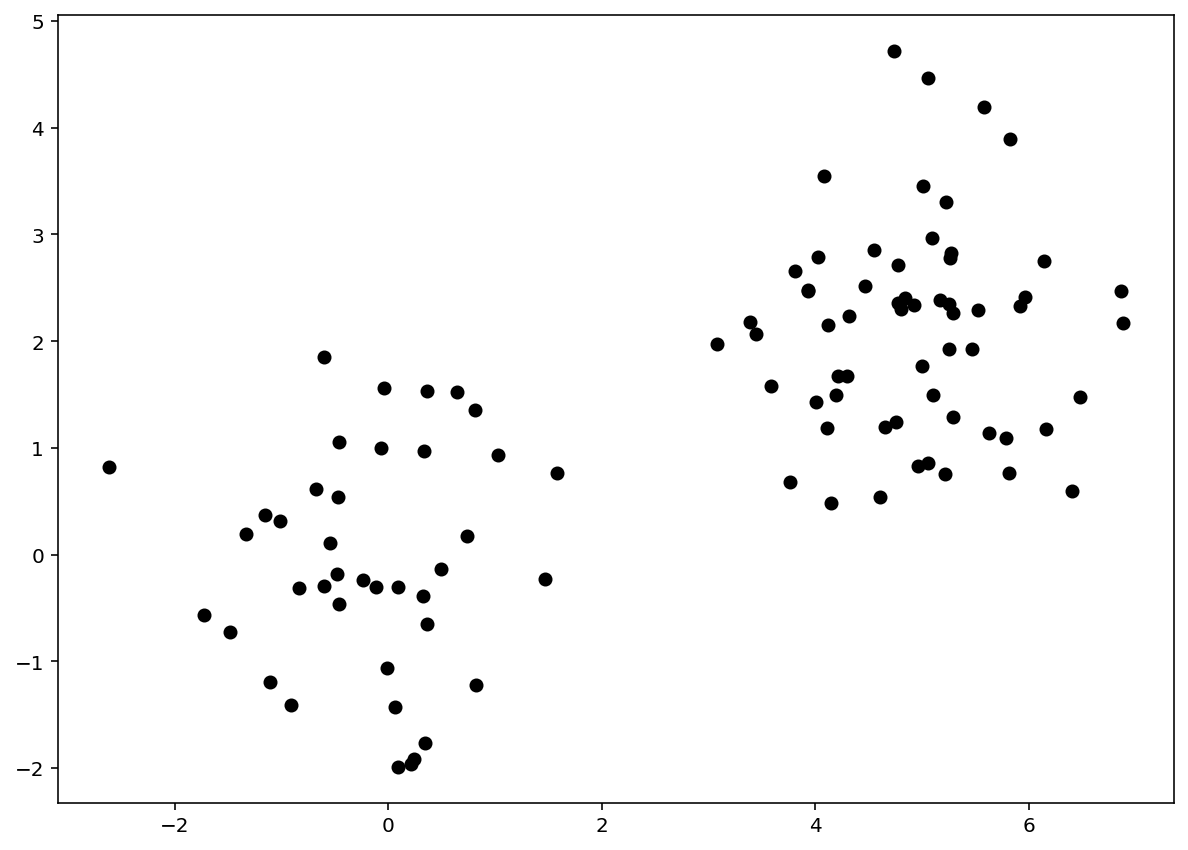

In [54]:
plt.scatter(*data.T, color='black')
plt.gca().set_aspect('equal')

Construct the tree...

In [50]:
root = build_kd_tree(data)
root

KDInternalNode(dimension=0, threshold=4.080575765766197)

Ok, so the root node asks: "Is x >= 4.0805...". But this doesn't tell us much. Let's make some helper functions for plotting the cells of a k-d tree.

In [51]:
def draw_tree_cells(node, bbox, plot_kwargs=None):
    if plot_kwargs is None:
        plot_kwargs = {
            'color': 'black'
        }
        
    x_min, x_max, y_min, y_max = bbox
    if isinstance(node, KDInternalNode):
        if node.dimension == 0:
            plt.plot([node.threshold, node.threshold], [y_min, y_max], **plot_kwargs)
            bbox_left = [x_min, node.threshold, y_min, y_max]
            bbox_right = [node.threshold, x_max, y_min, y_max]
        else:
            plt.plot([x_min, x_max], [node.threshold, node.threshold], **plot_kwargs)
            bbox_left = [x_min, x_max, y_min, node.threshold]
            bbox_right = [x_min, x_max, node.threshold, y_max]
        
        draw_tree_cells(node.left, bbox_left, plot_kwargs)
        draw_tree_cells(node.right, bbox_right, plot_kwargs)
        
def bounding_box(data):
    x, y = data.T
    return [x.min(), x.max(), y.min(), y.max()]

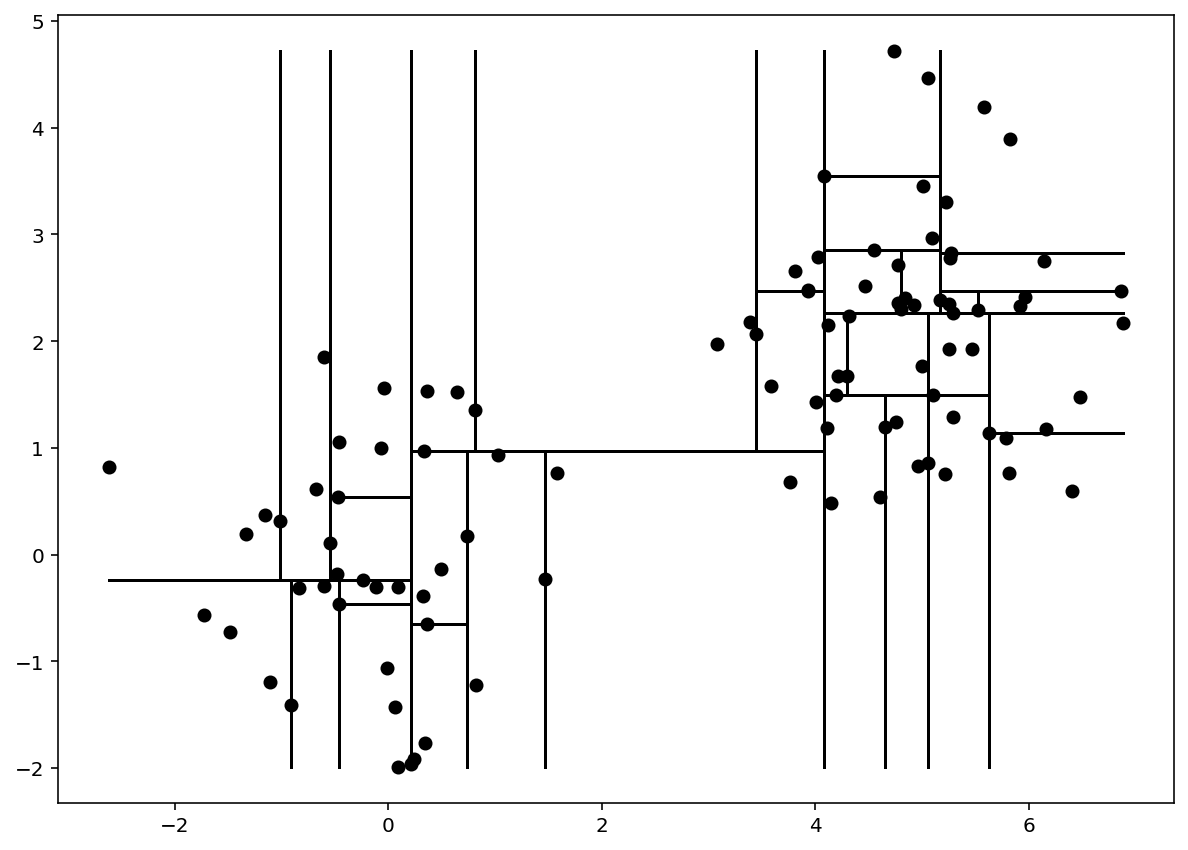

In [53]:
draw_tree_cells(root, bounding_box(data))
plt.scatter(*data.T, color='k')
plt.gca().set_aspect('equal')

## Querying

Let's query our tree. First we need a function to perform a brute-force query. This is used to search the leaf nodes of the tree.

In [55]:
def brute_force_nn_search(data, p):
    """Perform a brute force NN search.
    
    Parameters
    ----------
    data : ndarray
        An n x d array of n points in d dimensions.
    p : ndarray
        A d-array representing a query point.
        
    Returns
    -------
    ndarray
        The nearest neighbor of p.
    float
        The distance to the nearest neighbor.
        
    """
    distances = np.sqrt(np.sum((data - p)**2, axis=1))
    ix_of_nn = np.argmin(distances)
    nn = data[ix_of_nn]
    nn_distance = distances[ix_of_nn]
    return (nn, nn_distance)

Now we implement our nearest neighbor query function. The below implementation is capable of performing both *exact* NN queries (when $\alpha = 1$) or *approximate* neighbor queries (when $\alpha > 1$).

In [56]:
def nn_query(node, p, alpha=1):
    """Returns closest point to p in subtree, along with its distance to p.
    
    Parameters
    ----------
    node : KDInternalNode
        The node whose subtree will be searched.
    p : ndarray
        A d-array representing the query point.
    alpha : float
        The approximation parameter. If alpha = 1, exact NN is found. The larger
        alpha is, the more approximate the answer. Default: 1.
    
    Returns
    -------
    ndarray
        The nearest neighbor of p.
    float
        The distance to the nearest neighbor.
    """
    if alpha < 1:
        raise ValueError('alpha must be >= 1')
        
    if isinstance(node, np.ndarray):
        return brute_force_nn_search(node, p)
    else:
        # print('\t' * tabs, f'is dimension {node.dimension} >= {node.threshold}?')
        # find the most likely branch
        if p[node.dimension] >= node.threshold:
            most_likely_branch, other_branch = node.right, node.left
        else:
            most_likely_branch, other_branch = node.left, node.right

        # compute distance to boundary
        distance_to_boundary = abs(p[node.dimension] - node.threshold)

        # find nn within most likely branch
        nn, nn_distance = nn_query(most_likely_branch, p, alpha=alpha)
        
        # check the other branch, but only if necessary
        if distance_to_boundary < nn_distance / alpha:
            nn_other, nn_other_distance = nn_query(other_branch, p, alpha=alpha)
            if nn_other_distance < nn_distance:
                nn = nn_other
                nn_distance = nn_other_distance

        return nn, nn_distance

Let's test it out by querying the nearest neighbor of the point [1, 2]:

In [59]:
nn_query(root, [1, 2])

(array([0.64768854, 1.52302986]), 0.5929788226098602)

Is this correct? We can test it against our brute force search:

In [60]:
brute_force_nn_search(data, [1, 2])

(array([0.64768854, 1.52302986]), 0.5929788226098602)

Note that even if we use an approximation factor of 3 (which allows the approximate answer to be up to three times as far as the exact answer), we still get the exact answer:

In [66]:
nn_query(root, [1, 2], alpha=3)

(array([0.64768854, 1.52302986]), 0.5929788226098602)

In practice, the approximate nearest neighbor is often better than $\alpha$ would suggest.